In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
# List of tickers to be downloaded
# You can uncomment the set of tickers you are interested in

tickers = ['IEF', 'TLT', 'SHY', 'TIP', 'HYG', 'LQD', 'AGG', 'BND', 'EMB', 'MUB', 'PFF', '^GSPC', 'TIP', '^GSPC', 'LQD', 'UDN', 'EURUSD=X', '^VIX', 'CL=F', '^IRX', '^FVX', '^TNX', '^TYX']

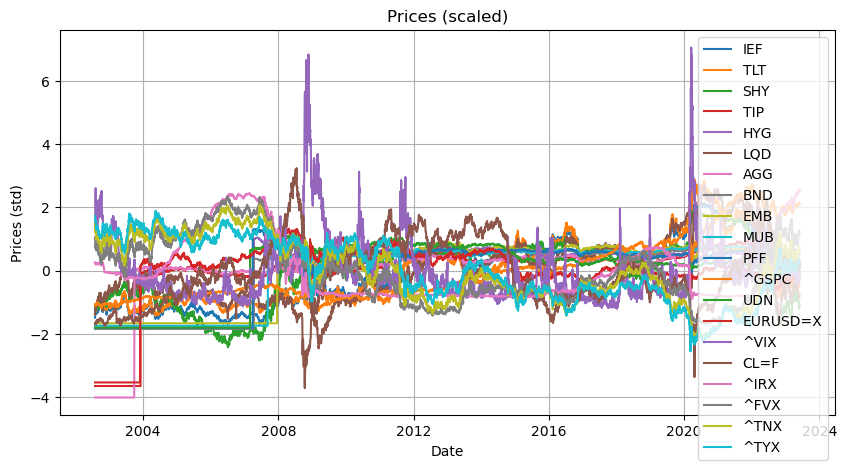

In [3]:
from basic_finance_tools import get_or_download_data, plot_df

# Specify the date range for data download
start = '2000-06-01'
end = '2023-06-01'

prices_data = get_or_download_data(tickers, start_date = start, end_date = end).ffill().fillna(0)

plot_df(prices_data, title= 'Prices', unit='USD', scaled=True)

In [4]:
from OptimalLinearSignal import *
from sklearn.preprocessing import StandardScaler

def compute_signal_OLS(pivot: pd.DataFrame, X: pd.DataFrame, training_size: int = 10, k_components:int=0, lambda_reg:float=1, l1_reg:float=0):
    signal = pd.DataFrame(index=pivot.index, columns=pivot.columns)
    
    for index_ticker, ticker in enumerate(pivot.columns):
        k_components = min(k_components, len(X.columns)-1)
        model = OptimalLinearSignal(pivot[ticker].diff(), lambda_reg, l1_reg, k_principal_components=k_components)
        scaler = StandardScaler()
        
        # Initialize DataFrame for predicted pivot
        signal.iloc[:training_size, index_ticker] = np.nan  # Filling with NaN
        
        # Perform online training and prediction
        for p in range(1, len(pivot) // training_size):

            index_day = p * training_size

            X_train = X.iloc[index_day - training_size: index_day-1, :].replace([np.inf, -np.inf], np.nan).ffill().fillna(0)
            X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
            model.fit(X_train_scaled)

            X_day = X.iloc[index_day : index_day + training_size, :].replace([np.inf, -np.inf], np.nan).ffill().fillna(0)
            X_scaled = pd.DataFrame(scaler.transform(X_day), columns=X_day.columns, index=X_day.index)

            predicted_signal = model.predict_optimal_signal(X_scaled)   
            corrective_term = np.sign(model.predict_optimal_pnl(X_scaled))
            
            signal.iloc[index_day : index_day + training_size, index_ticker] = predicted_signal.values * corrective_term.values
            
    return signal.ffill()


In [5]:
from basic_finance_tools import compute_position, compute_PNL, compute_metrics, plot_ds_hue

def show_strat_OLS(prices: pd.DataFrame, X: pd.DataFrame, ts: int, k:int = 1, l:float=1, l1_rat:float=0) -> None:
    """
    Demonstrates a trading strategy based on OLS and visualizes the results.
    """

    print({'ts': ts, 'k':k , 'l':l, 'l1_rat':l1_rat})
    
    pivot = prices[[prices.columns[0]]]
    try: signal = compute_signal_OLS(pivot, X, training_size=ts, k_components=k, lambda_reg=l, l1_reg=l1_rat, ) 
    except ValueError: signal=pd.DataFrame(0,index=pivot.index, columns=pivot.columns)

    positions = compute_position(signal, prices, threshold=1.5)
    pnl = compute_PNL(positions, prices)
    print(compute_metrics(pnl, positions))
    plot_ds_hue(pnl['DAILY'], pd.Series(signal.abs().mean(axis=1), index=signal.index), title="PNL")

In [6]:
X = pd.concat([prices_data.copy(),
               pd.DataFrame(prices_data.diff(), index=prices_data.index, columns=[str(col)+'.diff' for col in prices_data.columns]),
              # pd.DataFrame(prices_data.pct_change(), index=prices_data.index, columns=[str(col)+'.pct_change' for col in prices_data.columns]),
    ], axis=1)

prices = prices_data[[prices_data.columns[0]]]


{'ts': 60, 'k': 35, 'l': 10, 'l1_rat': 0.1}
{'sharpe_ratio': 0.55, 'turnover': 34.1, 'bips': 15.1, 'effective_sharpe_ratio': 1.11}


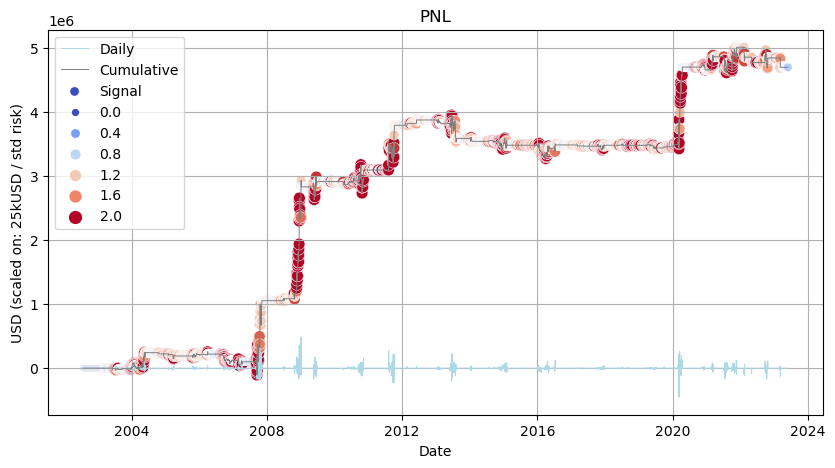

{'ts': 77, 'k': 6, 'l': 1, 'l1_rat': 0}
{'sharpe_ratio': 0.5, 'turnover': 35.3, 'bips': 11.9, 'effective_sharpe_ratio': 0.99}


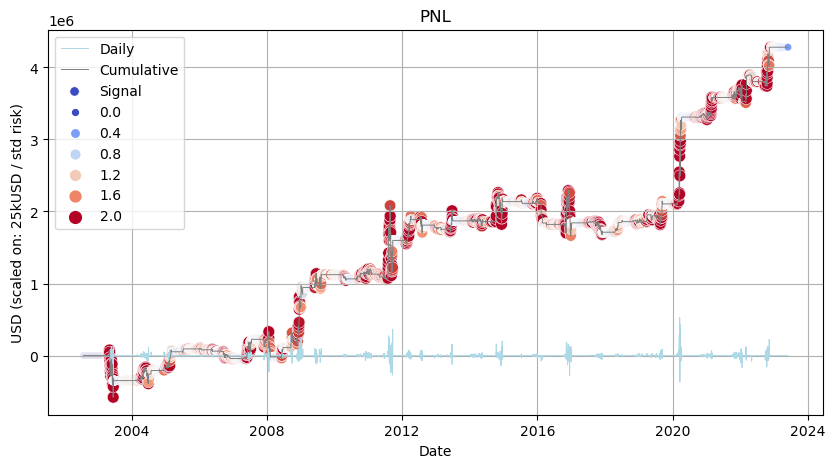

In [7]:
show_strat_OLS(prices, X, ts=60, k=35, l = 10, l1_rat=0.1,)
show_strat_OLS(prices, X, ts=77, k=6, l = 1, l1_rat=0,)

# 3 different trajectory of the PnL using 2 different parameters set

In [8]:
# Grid search optimization for wz1, wz2, wvt parameters for zscore strat
from basic_finance_tools import grid_search

def evaluate_OLS_strat(ts: int, k:int = 1, l:float=1, l1_rat:float=0, metric:str='sharpe_ratio') -> float:

    global prices, X
    
    pivot = prices[[prices.columns[0]]]
    try: signal = compute_signal_OLS(pivot, X, training_size=ts, k_components=k, lambda_reg=l, l1_reg=l1_rat, ) 
    except ValueError: return 0 
    positions = compute_position(signal, prices, threshold=1.5)
    pnl = compute_PNL(positions, prices)
    return np.abs(compute_metrics(pnl, positions)[metric])

# Define parameter ranges for grid search
param_grid = {
    'ts': np.linspace(55, 200, 20, dtype=int).tolist(),
    'k': [0, 1, 3, 5] + np.linspace(6, len(X.columns)-1, 6, dtype=int).tolist(),
    'l': [0.1, 10], #[0, 0.1, 0.5, 1, 10, ],
    'l1_rat': [0]
}

# Note that there is just a few 20 params for each 'ts'

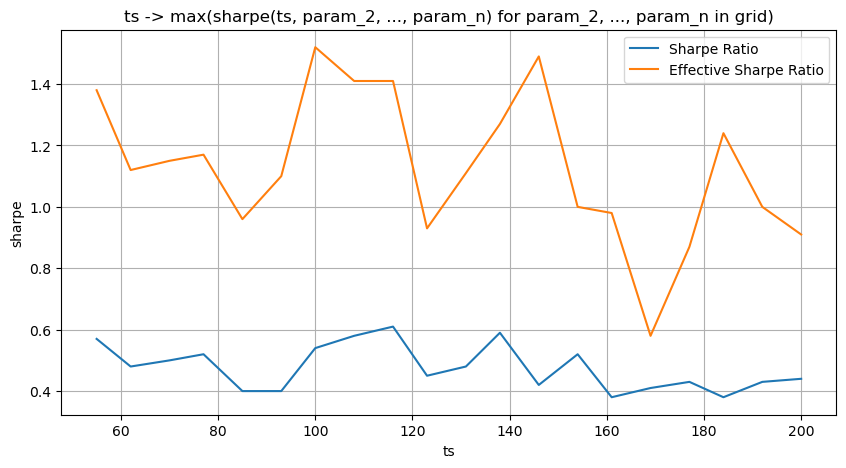



{'ts': 55, 'k': 19, 'l': 0.1, 'l1_rat': 0}
{'sharpe_ratio': 0.57, 'turnover': 32.9, 'bips': 18.8, 'effective_sharpe_ratio': 1.38}


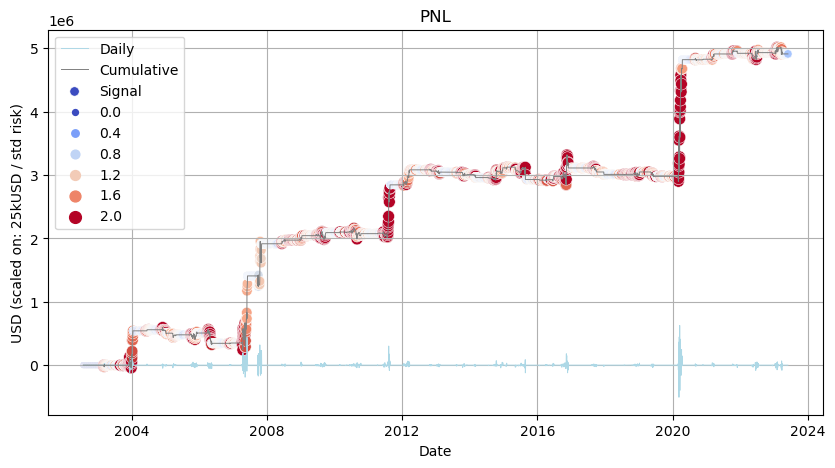

{'ts': 62, 'k': 19, 'l': 0.1, 'l1_rat': 0}
{'sharpe_ratio': 0.48, 'turnover': 33.8, 'bips': 16.2, 'effective_sharpe_ratio': 1.12}


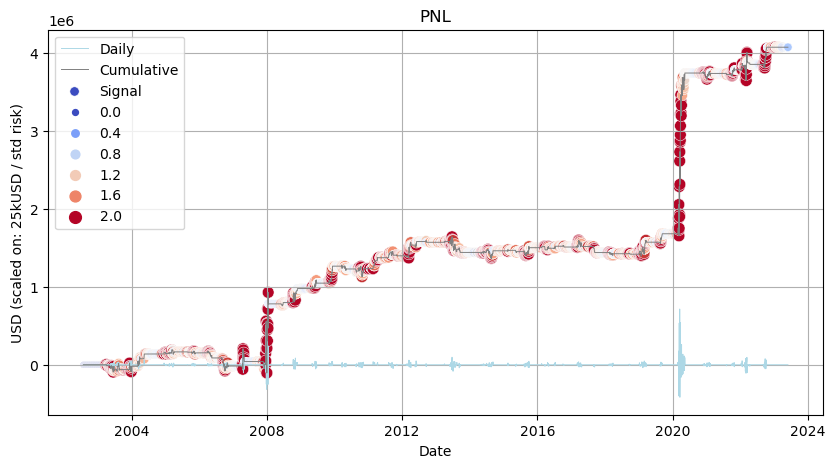

{'ts': 70, 'k': 25, 'l': 10, 'l1_rat': 0}
{'sharpe_ratio': 0.5, 'turnover': 33.7, 'bips': 14.3, 'effective_sharpe_ratio': 1.15}


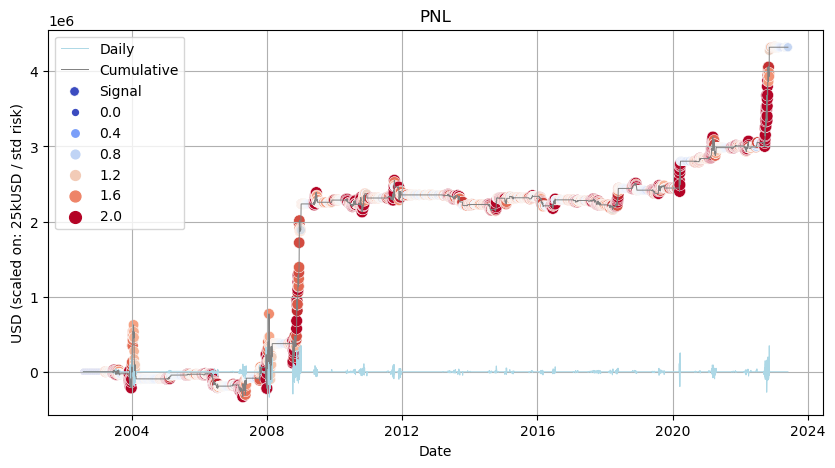

{'ts': 77, 'k': 12, 'l': 0.1, 'l1_rat': 0}
{'sharpe_ratio': 0.52, 'turnover': 34.6, 'bips': 11.5, 'effective_sharpe_ratio': 1.17}


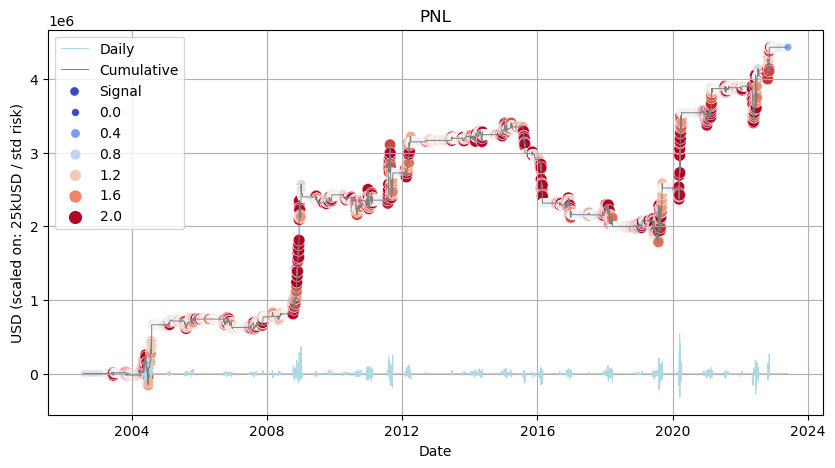

{'ts': 85, 'k': 6, 'l': 10, 'l1_rat': 0}
{'sharpe_ratio': 0.4, 'turnover': 35.8, 'bips': 14.1, 'effective_sharpe_ratio': 0.96}


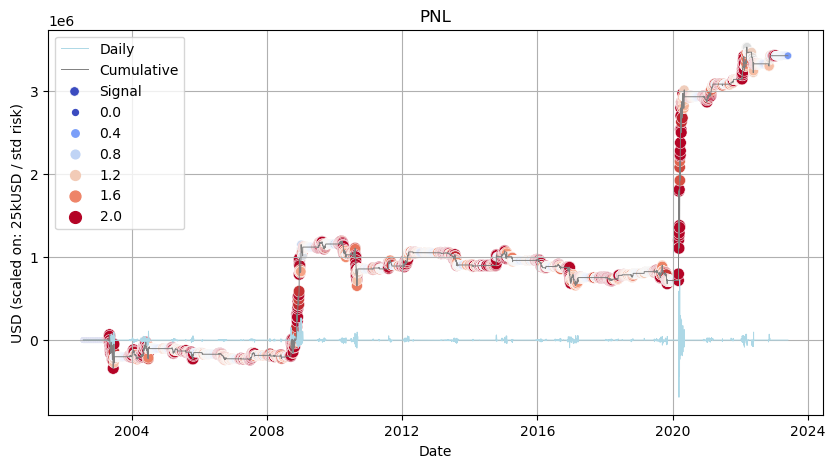

{'ts': 93, 'k': 39, 'l': 0.1, 'l1_rat': 0}
{'sharpe_ratio': 0.4, 'turnover': 34.7, 'bips': 10.2, 'effective_sharpe_ratio': 1.1}


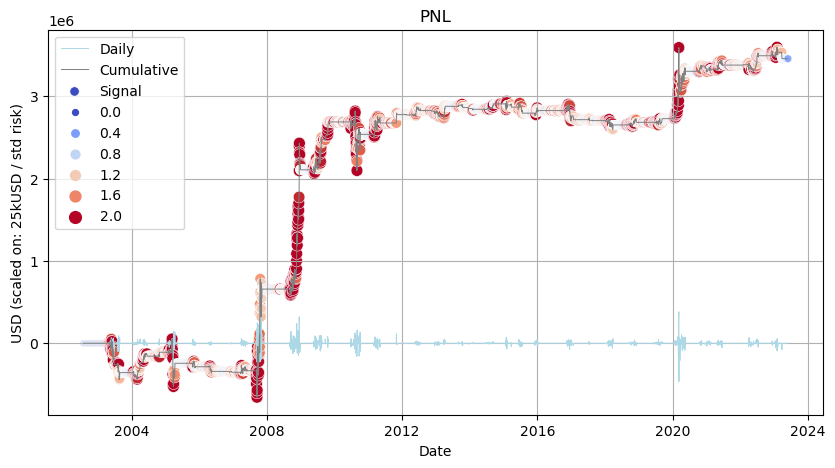

{'ts': 100, 'k': 32, 'l': 0.1, 'l1_rat': 0}
{'sharpe_ratio': 0.54, 'turnover': 37.1, 'bips': 10.9, 'effective_sharpe_ratio': 1.52}


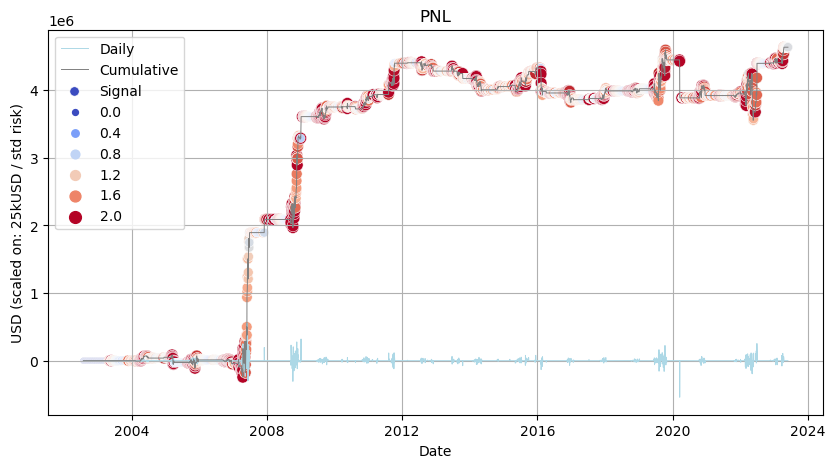

{'ts': 108, 'k': 12, 'l': 10, 'l1_rat': 0}
{'sharpe_ratio': 0.58, 'turnover': 46.0, 'bips': 13.2, 'effective_sharpe_ratio': 1.41}


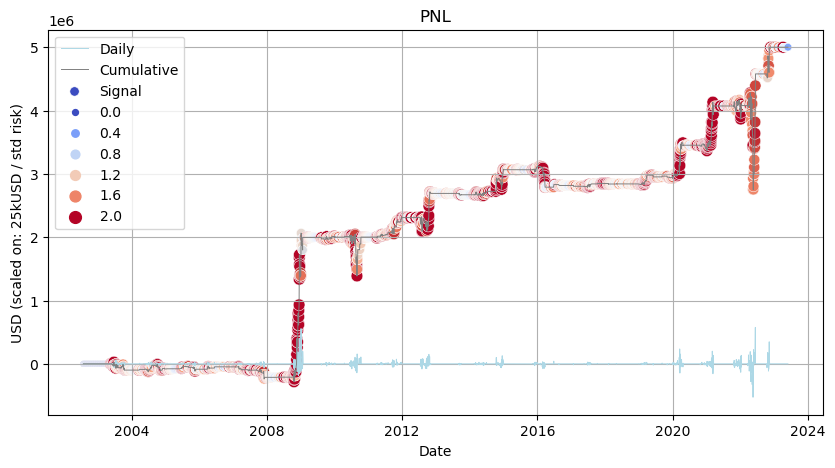

{'ts': 116, 'k': 19, 'l': 0.1, 'l1_rat': 0}
{'sharpe_ratio': 0.61, 'turnover': 36.0, 'bips': 14.6, 'effective_sharpe_ratio': 1.41}


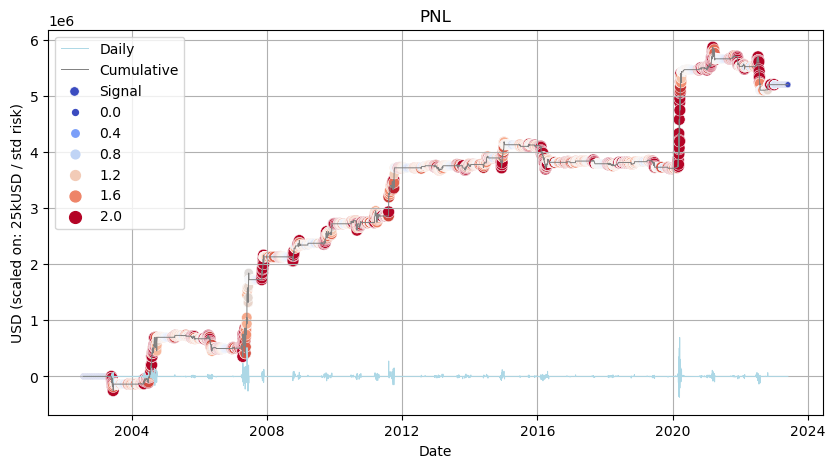

{'ts': 123, 'k': 0, 'l': 0.1, 'l1_rat': 0}
{'sharpe_ratio': 0.45, 'turnover': 41.0, 'bips': 11.1, 'effective_sharpe_ratio': 0.93}


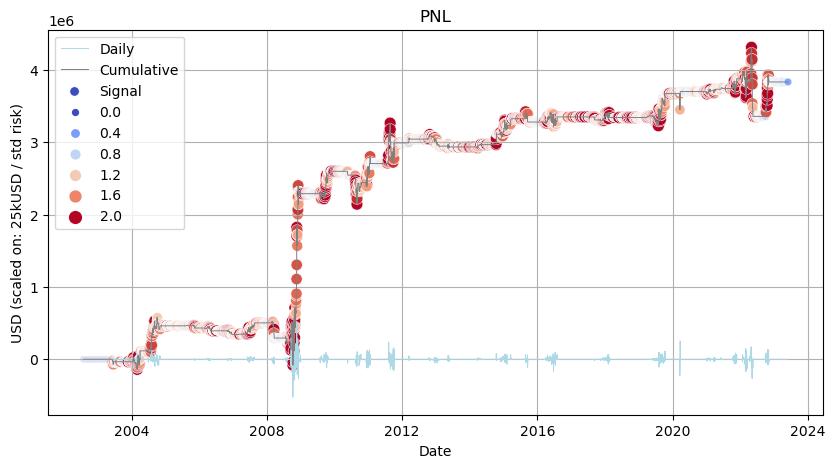

{'ts': 131, 'k': 19, 'l': 0.1, 'l1_rat': 0}
{'sharpe_ratio': 0.48, 'turnover': 32.7, 'bips': 10.7, 'effective_sharpe_ratio': 1.11}


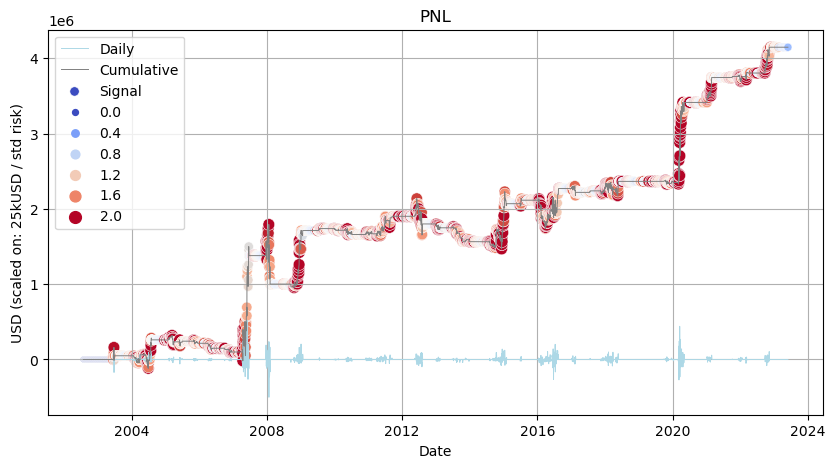

{'ts': 138, 'k': 6, 'l': 10, 'l1_rat': 0}
{'sharpe_ratio': 0.59, 'turnover': 36.6, 'bips': 13.5, 'effective_sharpe_ratio': 1.27}


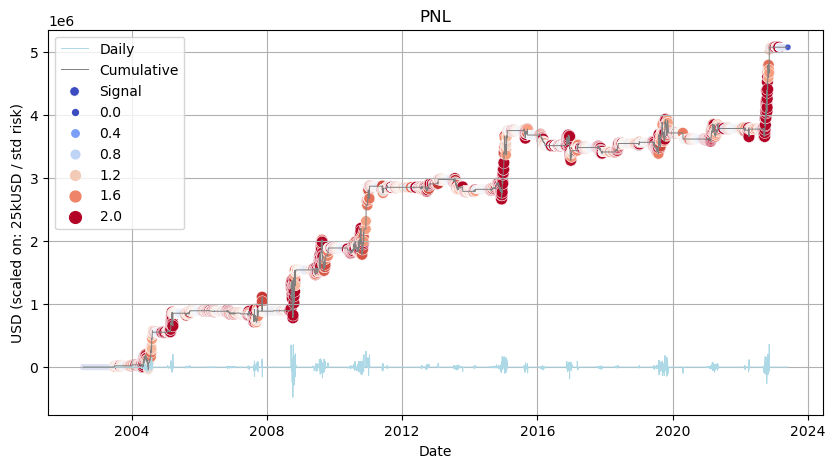

{'ts': 146, 'k': 39, 'l': 0.1, 'l1_rat': 0}
{'sharpe_ratio': 0.42, 'turnover': 41.2, 'bips': 9.7, 'effective_sharpe_ratio': 1.49}


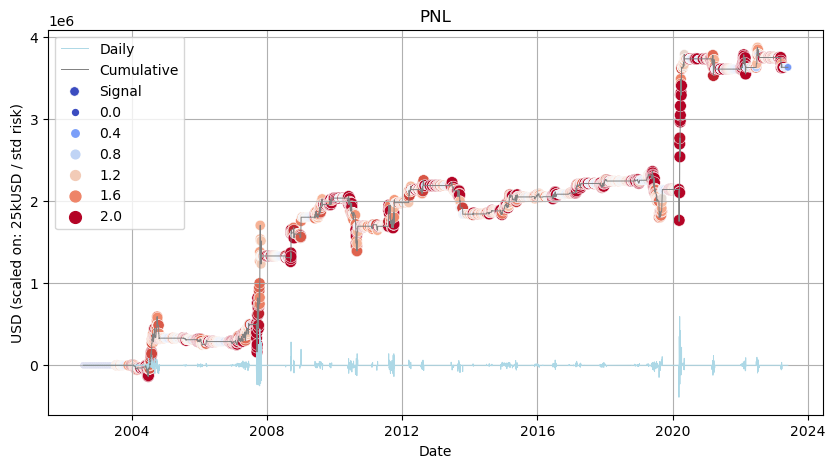

{'ts': 154, 'k': 19, 'l': 10, 'l1_rat': 0}
{'sharpe_ratio': 0.52, 'turnover': 35.1, 'bips': 17.2, 'effective_sharpe_ratio': 1.0}


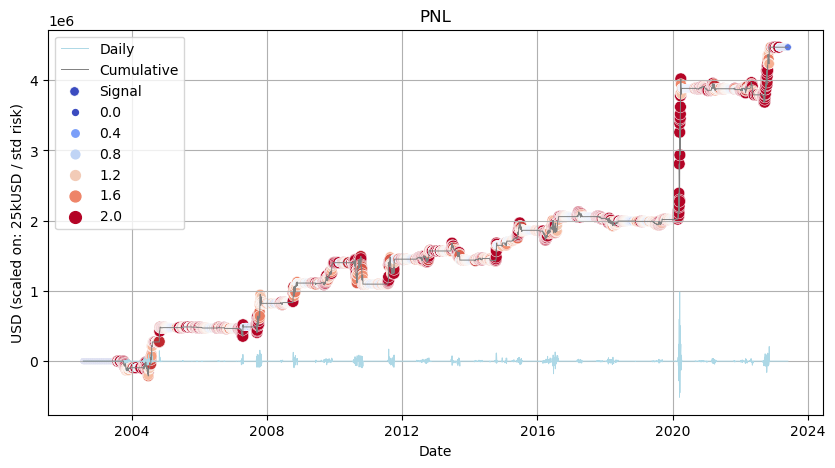

{'ts': 161, 'k': 32, 'l': 10, 'l1_rat': 0}
{'sharpe_ratio': 0.38, 'turnover': 32.6, 'bips': 17.9, 'effective_sharpe_ratio': 0.98}


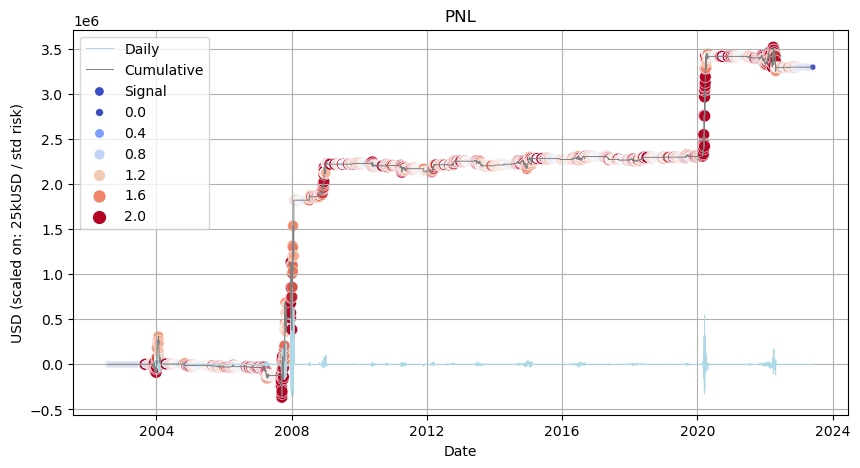

{'ts': 169, 'k': 3, 'l': 0.1, 'l1_rat': 0}
{'sharpe_ratio': -0.41, 'turnover': 34.5, 'bips': -18.8, 'effective_sharpe_ratio': -0.58}


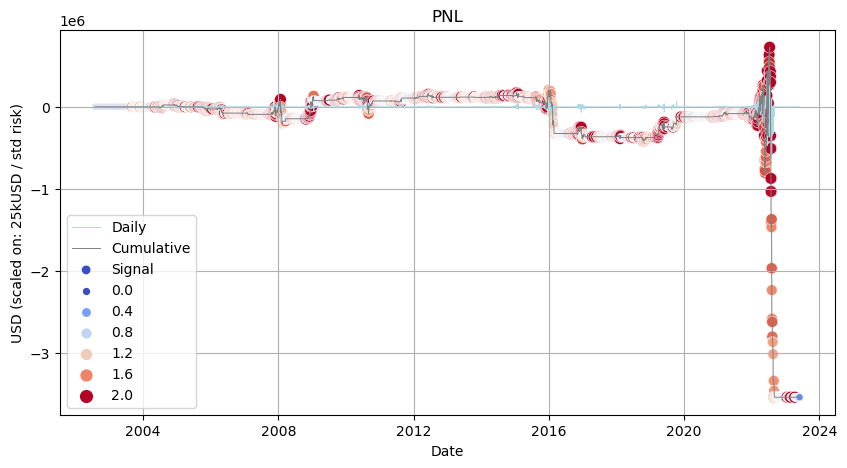

{'ts': 177, 'k': 0, 'l': 10, 'l1_rat': 0}
{'sharpe_ratio': 0.43, 'turnover': 42.9, 'bips': 8.7, 'effective_sharpe_ratio': 0.87}


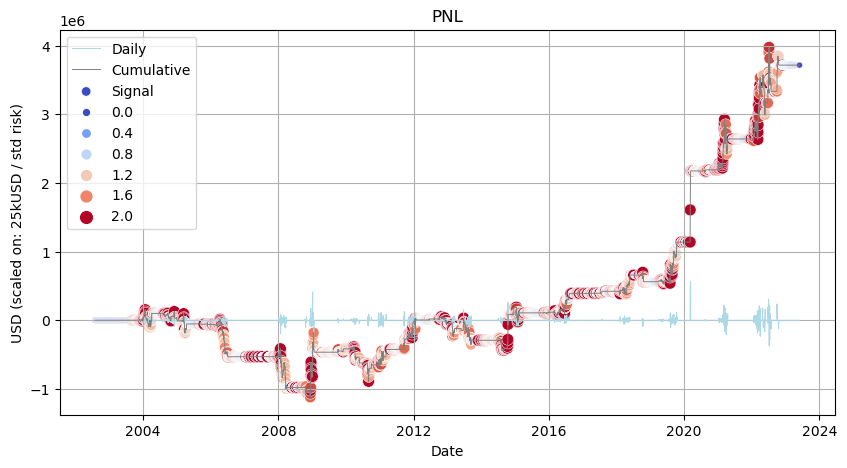

{'ts': 184, 'k': 0, 'l': 10, 'l1_rat': 0}
{'sharpe_ratio': 0.38, 'turnover': 34.9, 'bips': 9.8, 'effective_sharpe_ratio': 1.24}


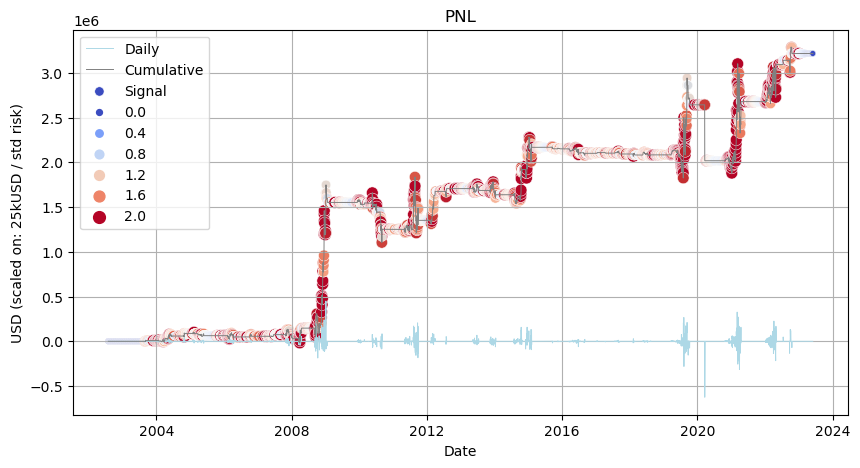

{'ts': 192, 'k': 12, 'l': 0.1, 'l1_rat': 0}
{'sharpe_ratio': 0.43, 'turnover': 38.9, 'bips': 12.6, 'effective_sharpe_ratio': 1.0}


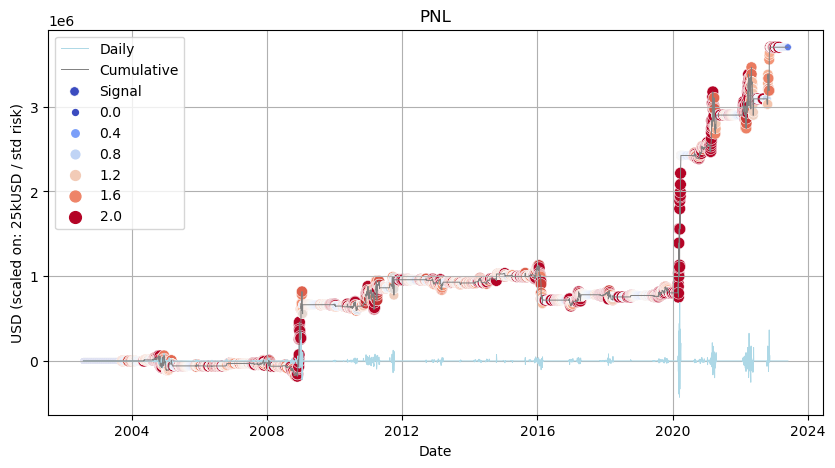

{'ts': 200, 'k': 39, 'l': 10, 'l1_rat': 0}
{'sharpe_ratio': 0.44, 'turnover': 28.0, 'bips': 18.3, 'effective_sharpe_ratio': 0.91}


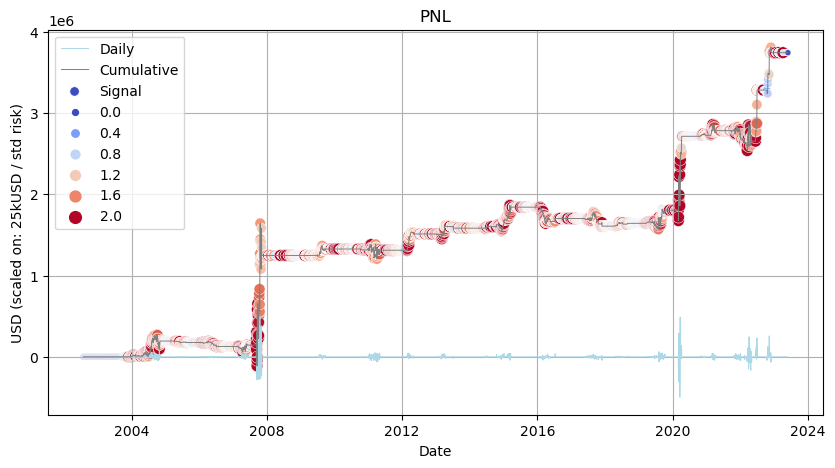

In [9]:
#Vizualise param_1 -> max(sharpe(param_1, param_2, ..., param_n) for param_2, ..., param_n in grid)
import matplotlib.pyplot as plt
import seaborn as sns 

param_selected = 'ts'
param_1_values = param_grid[param_selected]

param_grid_cut = {key: val for key, val in param_grid.items() if key != param_selected}

params_values = []
result_values = []
eff_result_values = []
for param_1 in param_1_values:
    best_params, best_result = grid_search(evaluate_OLS_strat, {**{param_selected:[param_1]}, **param_grid_cut,})
    params_values.append(best_params)
    result_values.append(best_result)
    eff_result_values.append(evaluate_OLS_strat(**{**best_params, **{'metric':'effective_sharpe_ratio'},}))

df = pd.DataFrame({
    param_selected: param_1_values,
    'sharpe': result_values,
    'eff_sharpe': eff_result_values
})

plt.figure(figsize=(10, 5))
plt.title(f'{param_selected} -> max(sharpe({param_selected}, param_2, ..., param_n) for param_2, ..., param_n in grid)')
plt.grid()
sns.lineplot(data=df, x=param_selected, y='sharpe', label='Sharpe Ratio')
sns.lineplot(data=df, x=param_selected, y='eff_sharpe', label='Effective Sharpe Ratio')
plt.legend()
plt.show()

print('\n')
for params in params_values: show_strat_OLS(prices, X, **params)